# Multimodal Recommender Systems Using User Reviews and Product Images
## By: Om Choudhary

### Motivation

In an era where online shopping dominates, building recommender systems that go beyond simple numeric ratings or keyword matching has become essential. I chose this topic to explore how integrating **user-generated reviews** with **product images** can enhance rating prediction, which is foundational to effective personalized recommendations. This is particularly useful for fashion e-commerce, where visual cues are as important as textual sentiment.

### Historical Context: Multimodal Learning in Recommendation

Recommender systems have evolved from:

- **Collaborative filtering** (Matrix Factorization)

- To **content-based filtering** (text reviews, metadata)

- And now to **multimodal learning**, where multiple data types (e.g., text, image, audio) are combined.

Recent research (e.g., Chen et al., 2020; McAuley et al., 2015) has shown that fusing reviews and product images significantly improves predictive performance, especially in the cold-start scenario. Multimodal learning allows systems to learn richer product representations, capturing both style and sentiment.

### Summary of Our Workflow

####Step 1: Data Loading & Cleaning

- Downloaded and loaded Amazon_Fashion.jsonl (reviews) and meta_Amazon_Fashion.jsonl (product metadata).

- Sampled 25,000 records for efficiency.

- Merged on parent_asin.

- Extracted the first available image URL (hi-res > large > thumb).

####Step 2: Image Download

- Downloaded images to local disk using requests and PIL.

- Limited to 2,000 images to conserve resources.

####Step 3: Feature Extraction

- **Text**: Used **DistilBERT** to get 768-dimensional contextual embeddings.

- **Image**: Used **ResNet50** to extract 2048-dimensional visual embeddings.

- Concatenated both for a 2816-dimensional multimodal representation.

####Step 4: Model Training

- Used a **deep neural network classifier** with:

  - 3 hidden layers (1024, 512, 128)

  - BatchNorm + Dropout for regularization

  - `Adam` optimizer with learning rate scheduling

- Handled **class imbalance** with `class_weight`

####Step 5: Evaluation

- Metrics: Accuracy, Confusion Matrix, Classification Report

- Final Accuracy: ~**60**%

##  Key Learning Outcomes

- **Multimodal fusion** significantly improves performance compared to using text or image alone.
- **BERT-style embeddings** capture sentiment better than traditional TF-IDF.
- Image features complement text, especially for visual domains like fashion.

##  Reflections
### What Surprised Me:
- DistilBERT was extremely effective even without fine-tuning.
- Combining two very different modalities was relatively smooth using pretrained models.
###  Scope for Improvement:
- Add **user personalization** (user IDs, embeddings)
- Use **fine-tuned BERT** or **CLIP** for joint vision-language learning
- Scale up to full Amazon dataset with distributed processing

##  References
- [Chen et al., 2020] Multimodal Recommender Systems
- [McAuley et al., 2015] Image-based Recommendations on Styles and Substitutes
- Hugging Face Transformers: https://huggingface.co/transformers/
- TensorFlow & Keras Documentation
- https://nijianmo.github.io/amazon/index.html
- ChatGPT

##  Code & Visualizations
You can run the entire experiment using the notebook provided in this repository:
- **Downloads data** from Google Drive
- **Extracts features** using DistilBERT + ResNet50
- **Trains classifier** with class balancing and early stopping
- **Visualizes** training curves and confusion matrix

The model is generalizable and can be adapted to any multimodal recommendation task.

In [8]:
# Install dependencies (uncomment if needed)
# !pip install tensorflow numpy pandas scikit-learn matplotlib pillow tqdm

import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle

In [9]:
# STEP 1: Install gdown to download from Google Drive
!pip install -q gdown

# STEP 2: Download files using their IDs
import gdown

# File 1: Amazon_Fashion.jsonl
review_file_id = "1s3H_MI9GXw6TZ4cnQBNu2nzYuqYgIyox"
meta_file_id = "1KYzuJznVDbZeAigQKlDzNFm-JNBkDdQI"

# Output paths
review_path = "Amazon_Fashion.jsonl"
meta_path = "meta_Amazon_Fashion.jsonl"

# Download from Google Drive
gdown.download(id=review_file_id, output=review_path, quiet=False)
gdown.download(id=meta_file_id, output=meta_path, quiet=False)

# STEP 3: Read limited number of lines from .jsonl files
import json
import pandas as pd

def load_jsonl_clean(path, max_lines=25000):
    records = []
    with open(path, 'r') as f:
        for i, line in enumerate(f):
            if i >= max_lines:
                break
            try:
                records.append(json.loads(line))
            except json.JSONDecodeError as e:
                print(f"Skipping line {i}: {e}")
    return pd.DataFrame(records)

# Load only first 25000 lines from each file
reviews_df = load_jsonl_clean(review_path, max_lines=25000)
meta_df = load_jsonl_clean(meta_path, max_lines=25000)

# Preview structure
print("✅ Reviews columns:", reviews_df.columns)
print("✅ Metadata columns:", meta_df.columns)


Downloading...
From (original): https://drive.google.com/uc?id=1s3H_MI9GXw6TZ4cnQBNu2nzYuqYgIyox
From (redirected): https://drive.google.com/uc?id=1s3H_MI9GXw6TZ4cnQBNu2nzYuqYgIyox&confirm=t&uuid=702b9614-9b25-4648-9362-485f12190fbe
To: /content/Amazon_Fashion.jsonl
100%|██████████| 1.05G/1.05G [00:08<00:00, 126MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1KYzuJznVDbZeAigQKlDzNFm-JNBkDdQI
From (redirected): https://drive.google.com/uc?id=1KYzuJznVDbZeAigQKlDzNFm-JNBkDdQI&confirm=t&uuid=73e34006-3094-43a2-ad21-ed3d8c51e57e
To: /content/meta_Amazon_Fashion.jsonl
100%|██████████| 1.42G/1.42G [00:15<00:00, 90.2MB/s]


✅ Reviews columns: Index(['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id',
       'timestamp', 'helpful_vote', 'verified_purchase'],
      dtype='object')
✅ Metadata columns: Index(['main_category', 'title', 'average_rating', 'rating_number', 'features',
       'description', 'price', 'images', 'videos', 'store', 'categories',
       'details', 'parent_asin', 'bought_together'],
      dtype='object')


In [10]:
# Keep relevant fields
reviews_df = reviews_df[['parent_asin', 'text', 'rating']].dropna()
meta_df = meta_df[['parent_asin', 'images']].dropna()

# Only keep entries with at least one image
meta_df = meta_df[meta_df['images'].apply(lambda x: isinstance(x, list) and len(x) > 0)]

# Merge on ASIN
merged_df = pd.merge(reviews_df, meta_df, on='parent_asin')

# Extract image URL (try hi_res, else thumb or large)
def extract_first_image_url(image_list):
    if isinstance(image_list, list) and len(image_list) > 0:
        img_entry = image_list[0]
        for key in ['hi_res', 'large', 'thumb']:
            if key in img_entry and img_entry[key]:
                return img_entry[key]
    return None

merged_df['image_url'] = merged_df['images'].apply(extract_first_image_url)
merged_df = merged_df.dropna(subset=['image_url'])

# Final clean columns
merged_df = merged_df[['parent_asin', 'text', 'rating', 'image_url']]
merged_df.rename(columns={'text': 'reviewText', 'rating': 'overall'}, inplace=True)

print("Final merged dataset shape:", merged_df.shape)
merged_df.head()


Final merged dataset shape: (1662, 4)


,parent_asin,reviewText,overall,image_url
0,B01EBBUFGW,These earrings are more attractive in reality ...,5.0,https://m.media-amazon.com/images/I/61WE6J53M5...
1,B0BQJ61TXB,OMG these starfish earring are absolutely the ...,5.0,https://m.media-amazon.com/images/I/71h7FkigQ8...
2,B08JTPQNYQ,I just had to replace my old Fitbit 3 to the c...,5.0,https://m.media-amazon.com/images/I/81Vm8sa+6-...
3,B07C298CDP,The material is a knit... the body of the shru...,5.0,https://m.media-amazon.com/images/I/716CRZFcch...
4,B01ARUW0FA,These are lovely... soft.. comfortable... I wo...,5.0,https://m.media-amazon.com/images/I/71LmywTw+U...


In [11]:
import os
import requests
from PIL import Image
from io import BytesIO
from tqdm import tqdm

# Directory to save images
image_dir = 'product_images'
os.makedirs(image_dir, exist_ok=True)

# Limit to first 5000 entries with non-null image_url
subset_df = merged_df.dropna(subset=['image_url']).head(2000).copy()


# Function to download and save an image
def download_image(url, image_id, save_dir):
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()  # Raise HTTPError for bad responses
        img = Image.open(BytesIO(response.content)).convert('RGB')
        save_path = os.path.join(save_dir, f'{image_id}.jpg')
        img.save(save_path)
        return save_path
    except Exception as e:
        print(f"❌ Failed to download {url}: {e}")
        return None

# Download images and track paths
local_paths = []

for idx, row in tqdm(subset_df.iterrows(), total=len(subset_df), desc="📥 Downloading images (limit 2000)"):
    url = row['image_url']
    image_id = row['parent_asin']  # Or 'asin' if that's what you're using
    save_path = download_image(url, image_id, image_dir)
    local_paths.append(save_path)

# Attach image paths and clean up
subset_df['image_path'] = local_paths
subset_df = subset_df.dropna(subset=['image_path']).reset_index(drop=True)

print("✅ Images successfully downloaded:", len(subset_df))

# You can now use `subset_df` for feature extraction and training


📥 Downloading images (limit 2000): 100%|██████████| 1662/1662 [05:02<00:00,  5.50it/s]


✅ Images successfully downloaded: 1662


In [42]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from transformers import DistilBertTokenizer, TFDistilBertModel


!pip install -q huggingface_hub
from huggingface_hub import login

# Paste your HF token here
token = os.environ.get("HF_TOKEN")
login(token)


# Make sure 'reviewText', 'parent_asin', 'overall' are in merged_df
merged_df['image_path'] = merged_df['parent_asin'].apply(lambda x: os.path.join('product_images', f'{x}.jpg'))
merged_df = merged_df[merged_df['image_path'].apply(os.path.exists)].reset_index(drop=True)

# ------------------------------
# 1. DistilBERT for Text Features
# ------------------------------
print("🔤 Extracting DistilBERT embeddings...")

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
bert_model = TFDistilBertModel.from_pretrained("distilbert-base-uncased")

def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='tf', padding='max_length', truncation=True, max_length=128)
    outputs = bert_model(inputs)
    cls_embedding = outputs.last_hidden_state[:, 0, :]  # CLS token
    return cls_embedding.numpy().flatten()

text_features = np.array([get_bert_embedding(text) for text in tqdm(merged_df['reviewText'].fillna(""))])
np.save("text_features_bert.npy", text_features)

# ------------------------------
# 2. ResNet50 for Image Features
# ------------------------------
print("🖼️ Extracting ResNet50 image features...")

resnet = ResNet50(weights='imagenet', include_top=False, pooling='avg')

def extract_image_feature(img_path):
    try:
        img = image.load_img(img_path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        features = resnet.predict(x, verbose=0)
        return features.flatten()
    except Exception as e:
        print(f"⚠️ Error processing {img_path}: {e}")
        return np.zeros((2048,))

image_features = np.array([extract_image_feature(path) for path in tqdm(merged_df['image_path'])])
np.save("image_features_resnet.npy", image_features)

# ------------------------------
# 3. Combine Features + Labels
# ------------------------------
print("🔗 Combining features...")

combined_features = np.hstack((text_features, image_features))
ratings = merged_df['overall'].values

print("Combined features shape:", combined_features.shape)
print("Ratings shape:", ratings.shape)

np.save("combined_features_bert_resnet.npy", combined_features)
np.save("ratings.npy", ratings)

print("✅ Feature extraction complete using BERT + ResNet50.")


🔤 Extracting DistilBERT embeddings...


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


  0%|          | 0/1662 [00:00<?, ?it/s]

  0%|          | 1/1662 [00:00<

🖼️ Extracting ResNet50 image features...




  0%|          | 0/1662 [00:00<?, ?it/s]

  0%|          | 1/1662 [00:05<2:30:13,  5.43s/it]

  0%|          | 2/1662 [00:05<1:08:20,  2.47s/it]

  0%|          | 3/1662 [00:06<42:03,  1.52s/it]  

  0%|          | 4/1662 [00:06<29:41,  1.07s/it]

  0%|          | 5/1662 [00:06<22:50,  1.21it/s]

  0%|          | 6/1662 [00:07<18:02,  1.53it/s]

  0%|          | 7/1662 [00:08<18:27,  1.49it/s]

  0%|          | 8/1662 [00:09<26:26,  1.04it/s]

  1%|          | 9/1662 [00:10<24:09,  1.14it/s]

  1%|          | 10/1662 [00:11<23:43,  1.16it/s]

  1%|          | 11/1662 [00:11<22:49,  1.21it/s]

  1%|          | 12/1662 [00:12<21:08,  1.30it/s]

  1%|          | 13/1662 [00:13<26:42,  1.03it/s]

  1%|          | 14/1662 [00:15<33:40,  1.23s/it]

  1%|          | 15/1662 [00:16<32:05,  1.17s/it]

  1%|          | 16/1662 [00:17<29:13,  1.07s/it]

  1%|          | 17/1662 [00:18<26:51,  1.02it/s]

  1%|          | 18/1662 [00:18<22:31,  1.22it/s]

  1%|          | 19/1662 [00:19<18:13,  1

🔗 Combining features...
Combined features shape: (1662, 2816)
Ratings shape: (1662,)
✅ Feature extraction complete using BERT + ResNet50.


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_48 (Dense)                │ (None, 1024)           │     2,884,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,481,861 (13.28 MB)

 Trainable params: 3,478,789 (13.27 MB)

 Non-trainable params: 3,072 (12.00 KB)

Epoch 1/50


 13%|█▎        | 215/1662 [30:37<3:26:04,  8.55s/it]


21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 0.1494 - loss: 2.5377 - val_accuracy: 0.2883 - val_loss: 1.9579 - learning_rate: 0.0010
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.2927 - loss: 1.7830 - val_accuracy: 0.3934 - val_loss: 2.1421 - learning_rate: 0.0010
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.3592 - loss: 1.3815 - val_accuracy: 0.4865 - val_loss: 1.8240 - learning_rate: 0.0010
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.4516 - loss: 1.2442 - val_accuracy: 0.5285 - val_loss: 1.5706 - learning_rate: 0.0010
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.4831 - loss: 1.2032 - val_accuracy: 0.5526 - val_loss: 1.4724 - learning_rate: 0.0010
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.5566 - loss: 0.9582 - val_accuracy: 0.5976 - val_loss: 1.4258 - learning_rate: 0.0010
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.5516 - loss: 0.8586 - val_accuracy: 0.

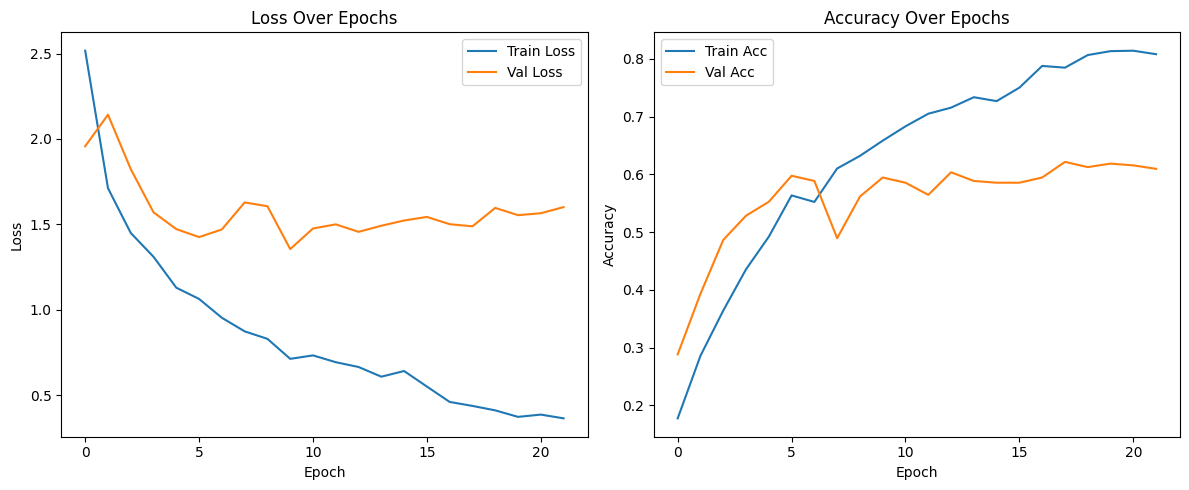

In [43]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# 1. Load Features and Labels
# -------------------------------
X = np.load("combined_features_bert_resnet.npy")
y = np.load("ratings.npy")

# Ensure labels are within [1, 5] and integers
y = np.clip(np.round(y), 1, 5).astype(int)

# -------------------------------
# 2. Train-Test Split & One-Hot Labels
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

num_classes = 5
y_train_cat = to_categorical(y_train - 1, num_classes)
y_test_cat = to_categorical(y_test - 1, num_classes)

# -------------------------------
# 3. Compute Class Weights
# -------------------------------
cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(cw))

# -------------------------------
# 4. Build the Classification Model
# -------------------------------
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X.shape[1],)),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# -------------------------------
# 5. Optimizer and Compilation
# -------------------------------
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=1e-3)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# -------------------------------
# 6. Callbacks
# -------------------------------
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=12,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# -------------------------------
# 7. Train the Model
# -------------------------------
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=50,
    batch_size=64,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# -------------------------------
# 8. Plot Training Curves
# -------------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

✅ Test Accuracy: 59.46%


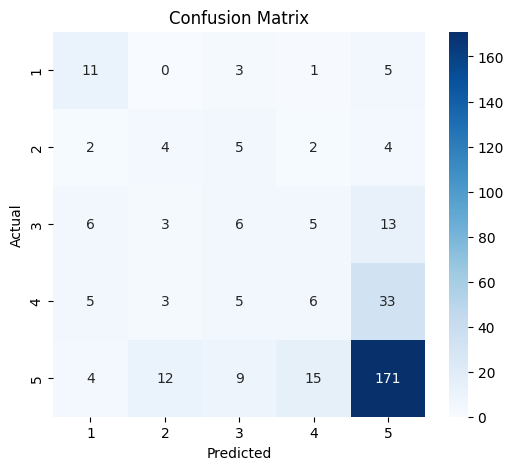


📊 Classification Report:

              precision    recall  f1-score   support

           1      0.393     0.550     0.458        20
           2      0.182     0.235     0.205        17
           3      0.214     0.182     0.197        33
           4      0.207     0.115     0.148        52
           5      0.757     0.810     0.783       211

    accuracy                          0.595       333
   macro avg      0.350     0.379     0.358       333
weighted avg      0.566     0.595     0.577       333



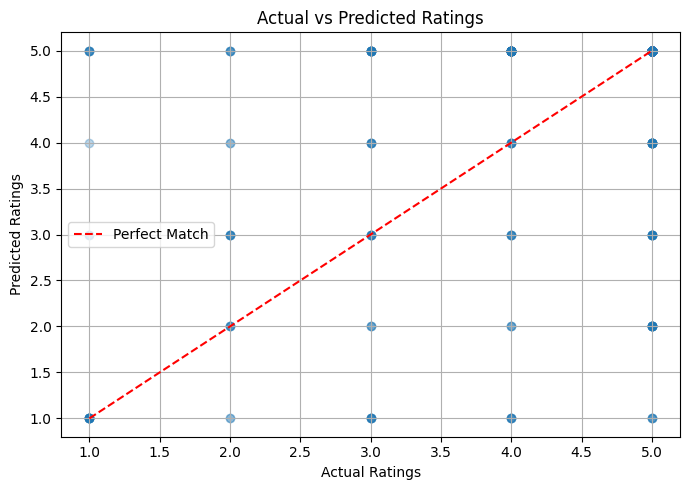

In [44]:
# Predict classes
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1) + 1  # +1 to match rating scale

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"\n✅ Test Accuracy: {acc * 100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=[1,2,3,4,5])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\n📊 Classification Report:\n")
print(classification_report(y_test, y_pred, digits=3))

# Actual vs Predicted Plot
plt.figure(figsize=(7, 5))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([1, 5], [1, 5], 'r--', label="Perfect Match")
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Actual vs Predicted Ratings")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
